# Analysis

To develop the best Machine Learning model it is important to analyse and understand the data feeding into the model, as well as the impact of certain parameters on the model performance.

The following tests were carried out to gain deeper understanding into the problem and to make design decision for the best final model.

## Data Loading

The following cells are for loading and setting up the data. The analysis starts at section "Data Exploration"

In [ ]:
import json
import re
from glob import glob
import tarfile

import numpy as np
import pandas as pd
from pathlib import Path
!pip install  radiant_mlhub
from radiant_mlhub import Dataset, Collection, client

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from IPython.display import HTML

import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data.dataset import random_split

import random

!pip install -q pycm livelossplot
from livelossplot import PlotLosses

from google.colab import drive
drive.mount('/content/gdrive/')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Load the API
!mlhub configure



API Key: 1b9e2a15f287a8844fef3944525e9712e67e30c441f032b3de5aa06780d6d7e4
Wrote profile to /root/.mlhub/profiles


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
colab = True
windows = False

train_source = 'nasa_tropical_storm_competition_train_source'

In [ ]:
# Download the data from Radiant ML Hub
dataset = Dataset.fetch('nasa_tropical_storm_competition')

# Print the names of available data
print('Source Imagery Collections\n--------------------------')
for collection in dataset.collections.source_imagery:
    print(collection.id)

print('')

print('Label Collections\n-----------------')
for collection in dataset.collections.labels:
    print(collection.id)

# Extract the data to contents file
!mkdir ./nasa_tropical_storm_competition

download_dir = Path('./nasa_tropical_storm_competition').expanduser().resolve()

archive_paths = dataset.download(output_dir=download_dir)
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
            tfile.extractall(path=download_dir)
print('Done')




Source Imagery Collections
--------------------------
nasa_tropical_storm_competition_train_source
nasa_tropical_storm_competition_test_source

Label Collections
-----------------
nasa_tropical_storm_competition_train_labels
nasa_tropical_storm_competition_test_labels


  0%|          | 0/1446.5 [00:00<?, ?M/s]

  0%|          | 0/918.3 [00:00<?, ?M/s]

  0%|          | 0/7.5 [00:00<?, ?M/s]

  0%|          | 0/4.6 [00:00<?, ?M/s]

Extracting /content/nasa_tropical_storm_competition/nasa_tropical_storm_competition_train_source.tar.gz...
Extracting /content/nasa_tropical_storm_competition/nasa_tropical_storm_competition_test_source.tar.gz...
Extracting /content/nasa_tropical_storm_competition/nasa_tropical_storm_competition_train_labels.tar.gz...
Extracting /content/nasa_tropical_storm_competition/nasa_tropical_storm_competition_test_labels.tar.gz...
Done


In [ ]:
# Load and Process the data to create a DataFrame
train_data = []

train_sources = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'

jpg_names = glob(str(download_dir / train_sources / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_sources, train_labels)

    # Create new field for image shape
    img = mpimg.imread(jpg_path)
    current_shape = img.shape
    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed']),
        str(current_shape)
    ])

# Create a dataFrame from all the loaded data
train_df = pd.DataFrame(
    np.array(train_data),
   columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed', 'Image Size']# contain space may be no convinent for indexing
).sort_values(by=['Image ID']).reset_index(drop=True)


In [ ]:
# Convert fields into numeric type
train_df['Wind Speed'] = train_df['Wind Speed'].apply(int)
train_df['Relative Time'] = train_df['Relative Time'].apply(int)
train_df['Ocean'] = train_df['Ocean'].apply(int)

# Print the data
train_df.head()



,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,Image Size
0,abs_000,abs,0,2,43,"(366, 366)"
1,abs_001,abs,1800,2,44,"(366, 366)"
2,abs_002,abs,5400,2,45,"(366, 366)"
3,abs_003,abs,17999,2,52,"(366, 366)"
4,abs_004,abs,19799,2,53,"(366, 366)"


## Data Exploration

Let us begin by understanding any anomalities and inconsistencies in the data. Since the model will be trained on a series of images, let us check the format and consistencies.

### Image Size

In [ ]:
#Number of Images
train_df.groupby('Image Size')['Image ID'].count().reset_index()

,Image Size,Image ID
0,"(1093, 1093, 3)",6020
1,"(366, 366)",64235
2,"(366, 366, 3)",2


Most of the images have 366x366 format with 1 channel, meaning that it is in grayscale. The other images have three channels, however,when opening the images we can see that they are in grayscale too. Therefore, we can merge the hurricanes with 3 channels into 1 channel without loss of information. For that purposes we have included a function in StormTensor to resize the images, where necessary.

The other difference in the images is the size. Most common images are 366x366, but there are some hurricanes that have more resolution and therefore may provide more detail for model training. We will assess the model on these storms too, to understand how the model deals with large images.

### Plot Data

To get an understanding of types of data we have, let us plot the wind speeds of different types of hurricane.

In [ ]:
# Create a function to plot wind speed
def plot_wind_speeds(storm_id):
    storm = train_df[train_df['Storm ID'] == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter(storm['Relative Time'], storm['Wind Speed'], color="lightgray")
    plt.xlabel("Relative Time")
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


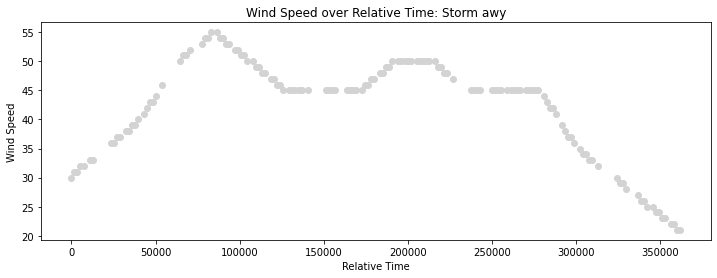

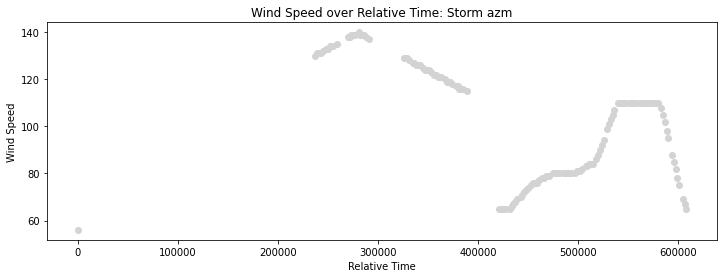

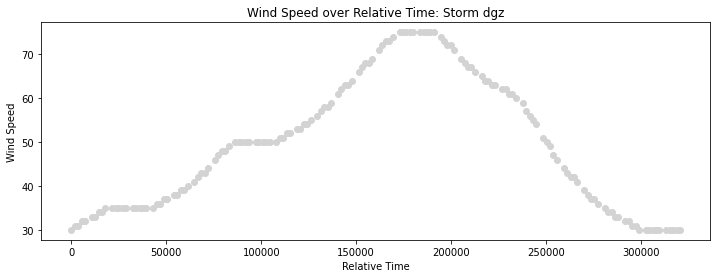

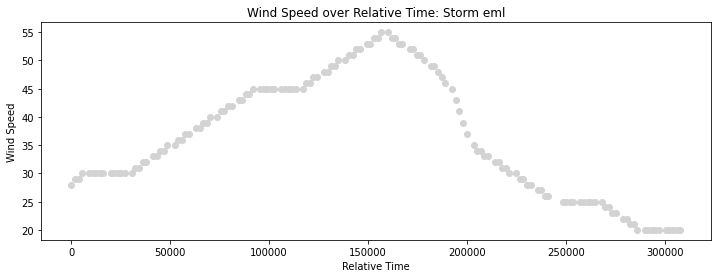

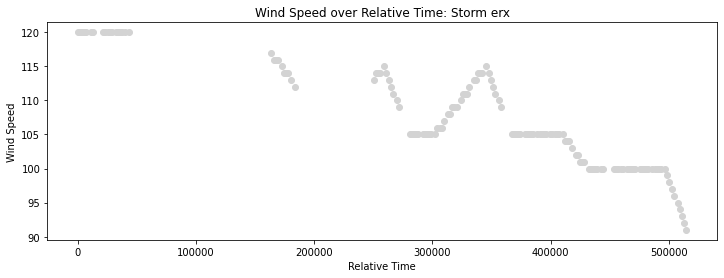

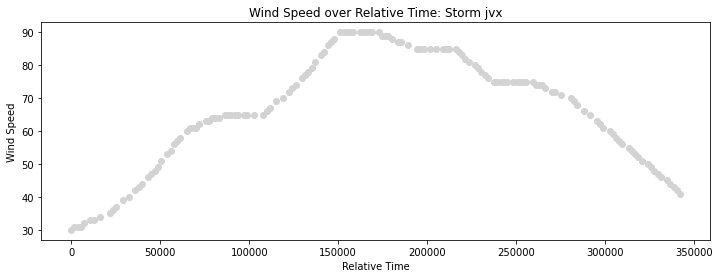

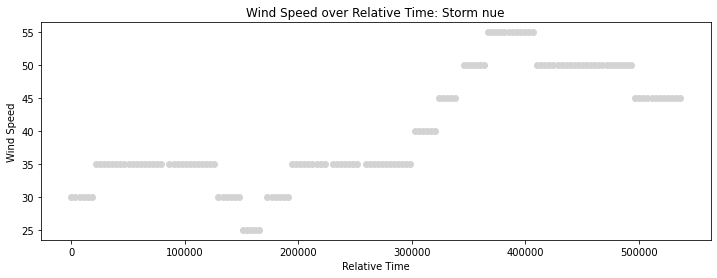

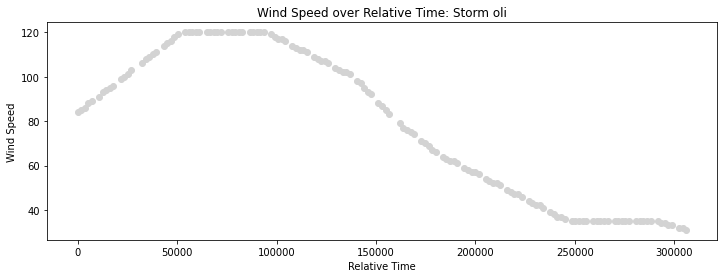

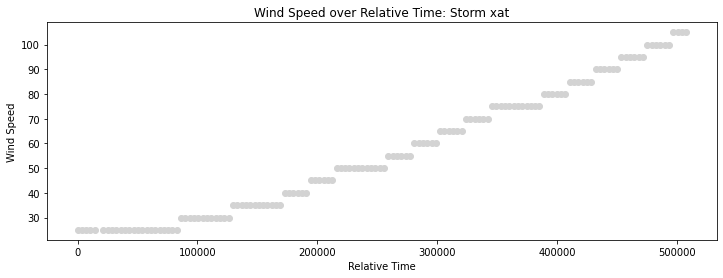

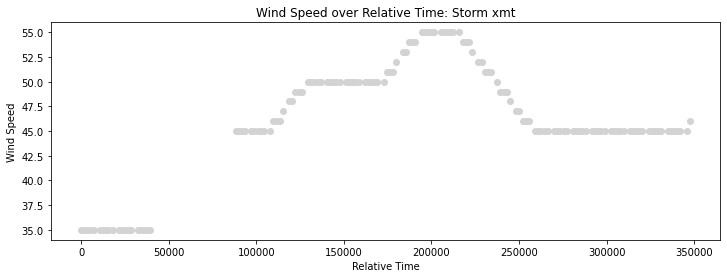

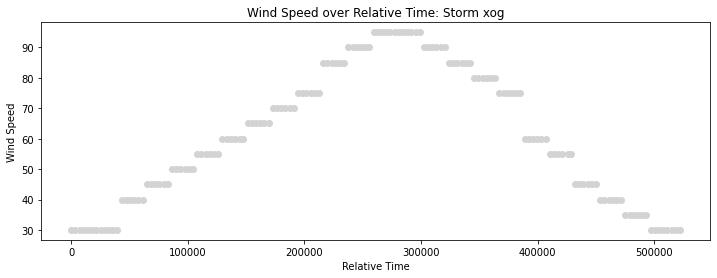

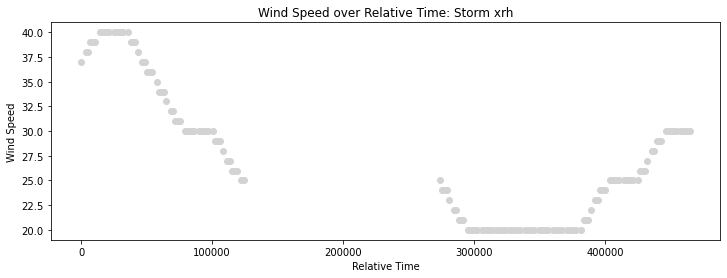

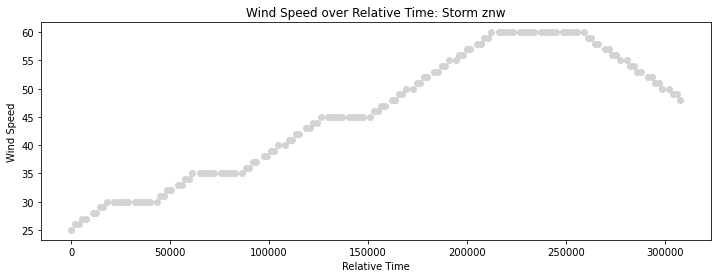

In [ ]:
# Calculate the nnumber of available images per hurricane
storms_count = train_df.groupby("Storm ID")['Image ID'].count() # calculate the number of images per hurricane
storms_wind = train_df.groupby(["Storm ID"])['Wind Speed'].agg(['min','max','mean','median']) # calculate the wind speed distribution
storms_wind.columns = 'wind_speed_' + storms_wind.columns 
##Take the Ocean and the Image Size 
storms_ocean = train_df.groupby(["Storm ID"])['Ocean','Image Size'].min() #

storms_df = pd.concat([storms_count,storms_ocean,storms_wind],axis=1) # combine the data
storms_df = storms_df.rename(columns={'Image ID':'num_images'}).reset_index()
storms_df_filtered = storms_df[(storms_df['num_images']>=140) & (storms_df['num_images']<=150)] # select a sample of hurricanes between 140 and 150 images

for storm_id in storms_df_filtered['Storm ID']:
    plot_wind_speeds(storm_id)



Based on the plots above we can see that there are many different types of hurricanes with different patterns in wind speeds. We should consider the impact of different wind speed trends may have on the results, for example, whether a higher wind speed may lead to worse performance.

We can also see from some of the storms that there are missing images in the data

### Missing Data

An important aspect of data is to take into consideration if there is any missing data. The images should have been taken every 30min, however, it is often the case that due to reason outside our control the images were not taken and there are gaps in the data. The length of missing data and the frequency may impact the model performance. Therefore it should be taken into account when the image data in analysed and model is trained.

Let us first explore how often are the images spaced less than (or more than) 30min (or 1800 seconds in the data)


In [ ]:
#Look at the distributions of displacements (when compared to module 1800)
# shift the data by 900 minute and take absolute value 
# this will allow to understand the distance of the image away from the designated 30min time
abs( ((train_df['Relative Time']+900)%1800)-900 ).value_counts().head()

1    29080
0    26548
2    11386
3     1690
4      585
Name: Relative Time, dtype: int64

We can see that if the image is present than it is within 5min of the deisgnated time. This is sufficiently close that should not have imapct on the results, therefore we can ignore the disparity


Next let us check how many hurricanes have missing images. 

In [ ]:

train_df_index1 = train_df[['Storm ID','Relative Time']].reset_index()
train_df_index2 = train_df_index1.copy()
train_df_index2['index'] = train_df_index2['index'] + 1 

train_df_index = pd.merge(left=train_df_index1,right=train_df_index2,on=['Storm ID','index'],how='inner')
train_df_index['differences'] = ( train_df_index['Relative Time_x'] - train_df_index['Relative Time_y'] )
train_df_index['differences'] = train_df_index['differences']/1800



gaps = train_df_index.groupby('Storm ID').differences.agg(['min','max']).reset_index()
gaps = gaps.rename(columns={'min':'min_gap','max':'max_gap'})
gaps = gaps.sort_values(by ='max_gap', ascending= False)
gaps.head(10)

,Storm ID,min_gap,max_gap
297,pxk,0.999444,358.000556
408,vtw,0.998333,269.998333
364,tlc,0.998333,229.000556
314,qyo,0.998889,210.001111
238,mju,0.998889,203.000556
95,epx,0.999444,173.999444
284,pjw,0.999444,158.999444
372,toz,0.999444,147.000000
24,azm,0.999444,132.000000
370,tnj,0.999444,131.000000


There appear to be some hurricanes with very large gaps in the data. The numbers above are how many images missing, so a gap of 358 means that there is 129 hour gap in the images! To better understand the severity of the problem, let us plot the distribution of maximum gaps.

(array([412.,  18.,   8.,   7.,   3.,   2.,   1.,   1.,   0.,   1.]),
 array([  2.00055556,  37.60055556,  73.20055556, 108.80055556,
        144.40055556, 180.00055556, 215.60055556, 251.20055556,
        286.80055556, 322.40055556, 358.00055556]),
 <a list of 10 Patch objects>)

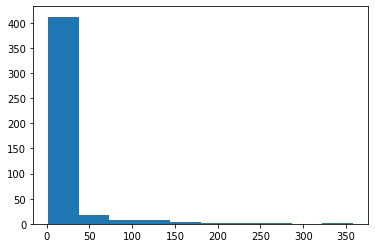

In [ ]:
plt.hist(gaps['max_gap'].where(gaps['max_gap']>2 )) # plot historgram of hurricanes that have at least 3 images missing

(array([319.,  66.,  10.,  12.,  11.,  10.,  14.,  11.,   6.,   5.]),
 array([ 1.99777778,  6.49794444, 10.99811111, 15.49827778, 19.99844444,
        24.49861111, 28.99877778, 33.49894444, 37.99911111, 42.49927778,
        46.99944444]),
 <a list of 10 Patch objects>)

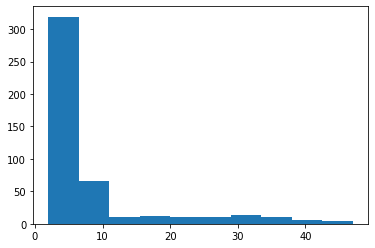

In [ ]:
plt.hist(gaps[ gaps['max_gap'] < 50 ]['max_gap'])


From the graph above we can see that majority of hurricanes with missing data have no more than 2.5 hours (5 gaps of 30min). So the extreme values in the table above are outliers. We should test our model on hurricanes with about 2-4 hour gaps in the data to check the impact of missing data on performance. Larger gaps are not representative of typical data that we would expect.

### Wind Distribution

We should also look for relationship in the data between different features. Although there is limited data available we can see if there is wind speed varies by ocean or if there are more (or less) images available for faster (or slower) hurricanes. This should allow us to understand correlation in the data and if there are any specific types of hurricanes there might be.

(array([ 0.,  2., 68., 81., 34., 14.,  9., 11.,  8.,  3.]),
 array([  1. ,  12.9,  24.8,  36.7,  48.6,  60.5,  72.4,  84.3,  96.2,
        108.1, 120. ]),
 <a list of 10 Patch objects>)

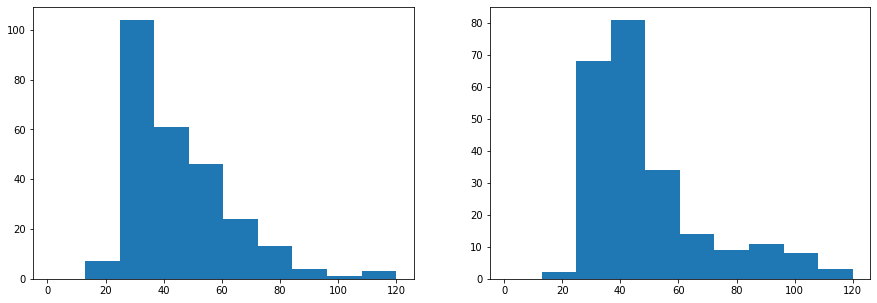

In [ ]:
# separate data into different location
storms_df_ocean1 = storms_df[storms_df['Ocean']==1]
storms_df_ocean2 = storms_df[storms_df['Ocean']==2]

fig, ax = plt.subplots(1,2,figsize=(15,5))
# plot the historgram of wind speed by different oceans
ax[0].hist(storms_df_ocean1['wind_speed_mean'], bins=10 , range=(1,120))
ax[1].hist(storms_df_ocean2['wind_speed_mean'], bins=10, range=(1,120))





We can see from histograms above that ocean 1 has lower mode speeds,however it is heavily skewed to the right. While on ocean 2 majority of the wind speeds are between 25 and 60, however are a lot more of faster hurricanes appearing in ocean 2. So in general in ocean two we are more likely to see faster hurricanes, which may impact the performance of the models and it is something we should consider when the model is being trained.

(array([104.,  57.,  34.,  14.,   7.,   6.,   4.,   2.,   1.,   1.]),
 array([  4. ,  61.2, 118.4, 175.6, 232.8, 290. , 347.2, 404.4, 461.6,
        518.8, 576. ]),
 <a list of 10 Patch objects>)

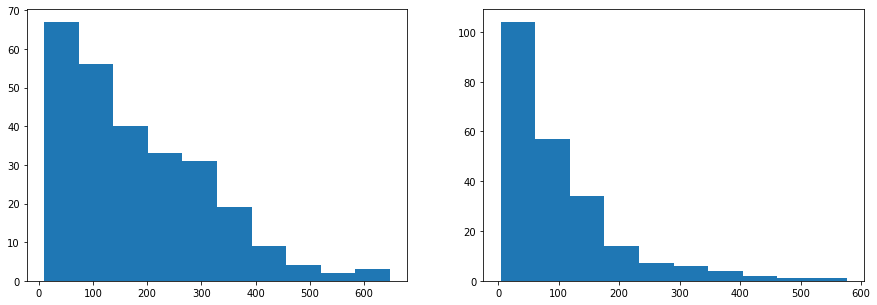

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
# Plot the number of images available by different oceans
ax[0].hist(storms_df_ocean1['num_images'], bins=10)
ax[1].hist(storms_df_ocean2['num_images'], bins=10)

Considering that we saw faster hurricanes in ocean 2, there are fewer images available for that location. It could be due to the fact that faster hurricanes might calm faster leaving with fewer images. Again this could have sever imapct on performance, because there is less information available and the difference from image to image  may vary more for faster hurricanes.

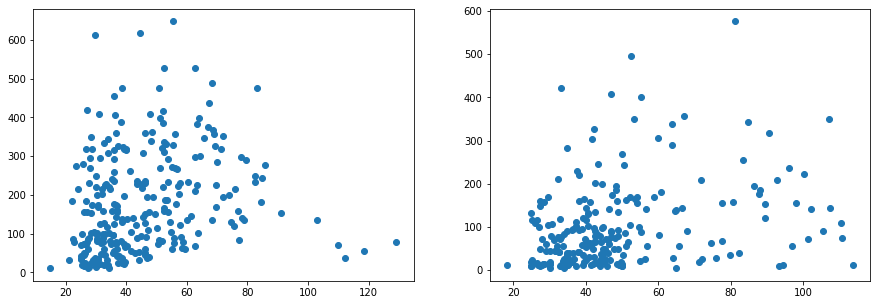

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
# Plotting the number of images by wind speed
ax[0].scatter(storms_df_ocean1['wind_speed_mean'], storms_df_ocean1['num_images'])
ax[1].scatter(storms_df_ocean2['wind_speed_mean'], storms_df_ocean2['num_images'])

Based on the scatterplots above, there doesnt seem to be a strong correlation between number of images availabel and the average speed split by different location. However we do see more images available in ocean 1 for across the different speeds. 

We will also exclud the hurricanes with fewer than 100 images, as it is not enough data to train the models accurately and more information is required. This would remove a fair portion of the ocean 2 data.

## Storm Classification

One of the ways to understand relationships in the data is to try and segment the hurricanes into different types. An efficient way to do that is to run an unsupervised algorithm to classify the data, for that purpose we can use K-means algorithm.

Below we take a selection of numeric features and run K-means algorithm for different number of clusters to understnad how many classes we might have in the data

In [ ]:

# to provide an implementation of the k-means algorithm
from sklearn.cluster import KMeans
# to scale our data so that we can perform "sensible" clustering
from sklearn.preprocessing import StandardScaler

# filter tha dataset to remove hurricanes with less than 100 images
storms_df_filtered = storms_df[(storms_df['num_images']>=100)]
storms_df_filtered=  storms_df_filtered.drop(['Storm ID', 'Image Size', 'wind_speed_median'], axis =1)
storms_df_filtered.head()

,num_images,Ocean,wind_speed_min,wind_speed_max,wind_speed_mean
1,123,1,30,60,43.162602
3,221,2,25,63,38.149321
4,129,2,22,50,40.527132
5,216,1,15,35,23.953704
8,293,1,25,65,36.040956


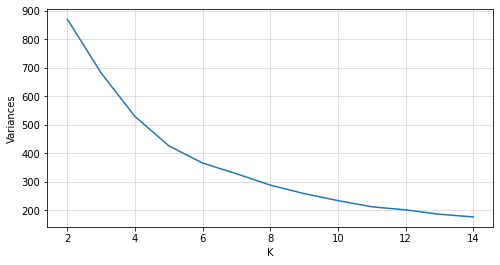

In [ ]:
KMeans_model = KMeans(n_clusters = 10, random_state = 123)
scaler = StandardScaler()
KMeans_model.fit(scaler.fit_transform(storms_df_filtered))

# create a list of different values of k to evaluate
k_values = list(range(2,15))

# create new models for each value of k and grab the models inertia_ 
# (i.e the within-cluster sum of squares which is essentially a measure of variance)
variances = [KMeans(k).fit(scaler.fit_transform(storms_df_filtered)).inertia_ for k in k_values]

# add the labels
storms_df_filtered['cluster'] = KMeans_model.labels_
storms_df_filtered.head()

#Visualise and look for 'kink' or 'elbow' in the graph
import seaborn as sns
plt.figure(figsize=(8,4))
sns.lineplot(x=k_values, y=variances)
plt.xlabel("K")
plt.ylabel("Variances")
plt.grid(alpha=0.5)
plt.show()

The plot above shows the drop is variance as we include more clusters in k-means algorithm. That means that we have less and less differentiation between the clusters. Based on "elbow" mthod, we would say that 5 or 6 segments is sufficient to classify the data.


Let us retrain the K-means algorithm with 5 clusters now and then plot the results. Although we have 5 different features in the data, it is impossible to view them all at once, so let us plot a few spearately to undertand how K-Means algorithm split the data.

In [ ]:
KMeansfinal = KMeans(n_clusters = 5, random_state = 123)
scaler = StandardScaler() 

KMeansfinal.fit(scaler.fit_transform(storms_df_filtered))

# add cluster labels
storms_df_filtered['cluster'] = KMeansfinal.labels_
storms_df_filtered.head()

,num_images,Ocean,wind_speed_min,wind_speed_max,wind_speed_mean,cluster
1,123,1,30,60,43.162602,2
3,221,2,25,63,38.149321,1
4,129,2,22,50,40.527132,1
5,216,1,15,35,23.953704,0
8,293,1,25,65,36.040956,2


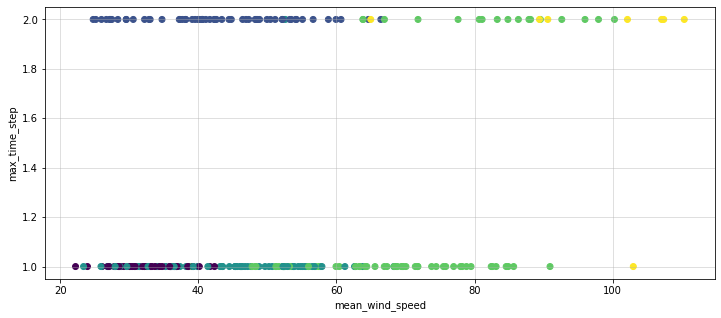

In [ ]:
# lets visualize our data in our reduced 2-dimensional space
plt.figure(figsize=(12, 5))
plt.scatter(storms_df_filtered["wind_speed_mean"], storms_df_filtered["Ocean"], c = storms_df_filtered["cluster"])
plt.xlabel('mean_wind_speed')
plt.ylabel('max_time_step')
# plt.ylim(0, 10000)
plt.grid(alpha=0.5)
plt.show()

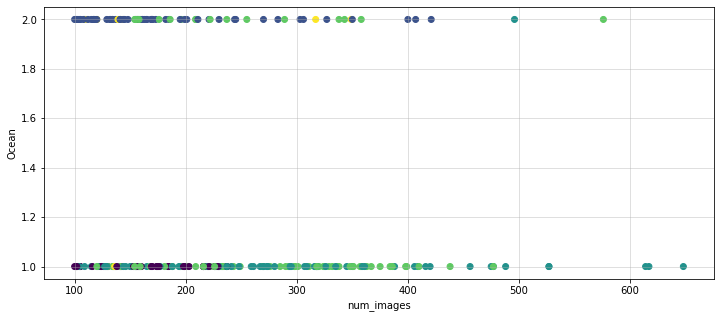

In [ ]:
# lets visualize our data in our reduced 2-dimensional space
plt.figure(figsize=(12, 5))
plt.scatter(storms_df_filtered["num_images"], storms_df_filtered["Ocean"], c = storms_df_filtered["cluster"])
plt.xlabel('num_images')
plt.ylabel('Ocean')
# plt.ylim(0, 10000)
plt.grid(alpha=0.5)
plt.show()

## Dimensionality Reduction

One thing we would like to incorporate in our model is dimensionality reduction. The goal of this is to compress and decompress our data so that very little information is lost. Once that is done, it is possible to train a model in the latent space. This model would take much less time to train given that the latent space has a small number of parameters to train in comparison to the original space.

We will explore the option of dimensionality reduction by applying to our data: 
- PCA
- Autoencoders 

and we will look at how much the test MSE is affected, to check if it is worth doing such reduction. We selected the storm 'jvx' to test the dimensionality reduction approaches.

### PCA

PCA is a linear approach to compression of the data. This approach decomposes the data in orthogonal vectors such that they are ordered by variance content. Then, it takes the ones that keep a certain desired percentage of the variance in the training data and by doing that we are compressing the data and also losing as little information as possible.

Given that for this dataset we have less images than number of pixels (which is not ideal in this approach) the number of vectors to decompose is limited to the number of images. Therefore, if we choose to keep 100% of the variance we will be keeping a number of vectors equal to the number of images and it will be possible to construct the training set without losing any information. However, predictions on the test set will depend on if there is a linear relation between future images and the previous images.

In [ ]:
import time 
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [ ]:
storm_selected = 'jvx'

num_images = train_df[train_df['Storm ID']==storm_selected].shape[0]

In [ ]:
storm_images_array = []

for image_id in train_df[train_df['Storm ID']==storm_selected]['Image ID']:    
    #jpg_path = image_folder + image_id + '/image.jpg'
    jpg_path = str(download_dir)+ '/'+train_sources+'/'+train_sources+ '_' + image_id + '/image.jpg'
    img = mpimg.imread(jpg_path)
    
    if len(img.shape)==2:
        temp_array = np.reshape(img, img.shape[0]*img.shape[1])
    elif len(img.shape)==3:
        temp_array = np.reshape(img, img.shape[0]*img.shape[1]*img.shape[2])
    
    storm_images_array.append(temp_array)

storm_images_array = np.array(storm_images_array)

train_data_array = storm_images_array[:-5]
test_data_array = storm_images_array[-5:]

Train execution time: 2.9369983673095703


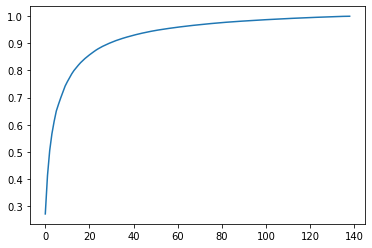

In [ ]:
start = time.time()

pca_compress = PCA(min(train_data_array.shape))
train_pca = pca_compress.fit_transform(train_data_array)
train_recovered = pca_compress.inverse_transform(train_pca)
varianceCumulative = np.cumsum(pca_compress.explained_variance_ratio_)

end = time.time()

train_execution_time = end-start
print(f'Train execution time:',train_execution_time)

plt.plot(varianceCumulative)

Train error

In [ ]:
#This should literally be zero
mse_train_error = mean_squared_error(train_data_array, train_recovered)
print(f'MSE: {mse_train_error }')

MSE: 7.123020378336043e-26


Test error

In [ ]:
test_pca = pca_compress.transform(test_data_array)
test_recovered = pca_compress.inverse_transform(test_pca)

#This is the MSE error
mse_test_error = mean_squared_error(test_data_array, test_recovered)
print(f'MSE: {mse_test_error }')

MSE: 674.659712520942


Note that the MSE test error is very high in comparison to the MSE train error. We can actually compute the MSE error for the last 10 values of the storm and check that for the first 5 of them (which are in the trainng set) the MSE results whereas the MSE error for the last 5 of those values (which are NOT in the trainng set) is very high. 

 This indicates that the data is highly non-linear and that the PCA is not generalizing well to unseen examples. 
 
 Therefore, unfortunately, using PCA is not an option. 

In [ ]:
for i in range(num_images-10,num_images):  #0,1,2,3
    #mini_test = storm_images_array[-(i+2):-(i+1)]
    mini_test = np.array([ storm_images_array[i] ])

    test_pca = pca_compress.transform(mini_test)
    test_recovered = pca_compress.inverse_transform(test_pca)

    mse_test_error = mean_squared_error(mini_test, test_recovered)
    print(f'MSE: {mse_test_error }')

MSE: 6.066147625062728e-26
MSE: 1.8195856574958861e-25
MSE: 7.887627279727175e-26
MSE: 1.6510084199654369e-25
MSE: 2.1374546830667396e-25
MSE: 474.26077616042113
MSE: 568.1936664136871
MSE: 681.3291837020541
MSE: 783.8839405640239
MSE: 865.630995764524


### Autoencoders

Autoencoders are another approach at dimensionality reduction. Whereas significantly computationally more expensive to train in comparison with PCA, their non-linearity makes them prone to produce better results.

The following autoencoder (along with its training function) were taken and modified from this source:
https://www.geeksforgeeks.org/implement-deep-autoencoder-in-pytorch-for-image-reconstruction/

In [ ]:
def get_image(image_id):
    """
    A function that returns the image represented by image_id as a tensor.

    Path is the path to the directory that stores the downloaded dataset.
    """
    #jpg_path = image_folder + image_id + '/image.jpg'
    jpg_path = str(download_dir)+ '/'+train_sources+'/'+train_sources+ '_' + image_id + '/image.jpg'
    img = torchvision.io.read_image(jpg_path)
    return img

def get_storm_images(storm_id):
  
    storm_df = train_df[train_df['Storm ID'] == storm_id]
    storm_images = []

    for image_id in storm_df['Image ID']:
        img_tensor = get_image(image_id)
        if img_tensor.shape[0] != 1 or img_tensor.shape[1] != 366 or img_tensor.shape[2] != 366:
            print(image_id, 'has shape [%.d, %.d, %.d]' % (img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2]))
        storm_images.append(img_tensor)

    storm_images = torch.cat(storm_images, dim=0)

    return storm_images

In [ ]:
storm_images_array = get_storm_images('awy')
storm_images_array = storm_images_array/255

storm_train_images = storm_images_array[:-5]   #train_data_array
storm_test_images  = storm_images_array[-5:]   #test_data_array

In [ ]:
mean = torch.mean(storm_train_images.flatten()).item()
std = torch.std(storm_train_images.flatten()).item()
print(mean, std)

0.3247627019882202 0.23812854290008545


In [ ]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(366*366, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 366*366),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
  

 # Instantiating the model and hyperparameters
model = DeepAutoencoder()
criterion = torch.nn.MSELoss()
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
tune_batch_size = 256
test_batch_size = 256

td_train = TensorDataset(storm_train_images, storm_train_images.long())
td_test = TensorDataset(storm_test_images, storm_test_images.long())

train_loader = DataLoader(td_train, batch_size=tune_batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(td_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

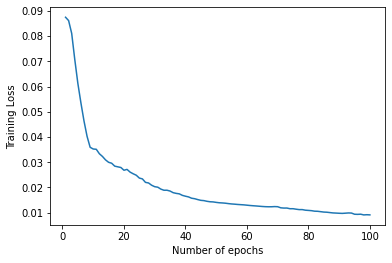

In [ ]:
# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
batch_size = len(train_loader)
  
# Training loop starts
for epoch in range(num_epochs):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    # Iterating over the training dataset
    for batch in train_loader:
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch  
        img = img.reshape(-1, 366*366)
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

Train error

In [ ]:
# Extracting the last batch from the train dataset
img, _ = list(train_loader)[-1]
  
# Reshaping into 1d vector
img = img.reshape(-1, 366*366)
  
# Generating output for the obtained
# batch
out = model(img)

mse_train_error = mean_squared_error(img.detach().numpy(), out.detach().numpy())
print(f'MSE: {mse_train_error }')

MSE: 0.008886132389307022


In [ ]:
# Extracting the last batch from the test dataset
img, _ = list(test_loader)[-1]
  
# Reshaping into 1d vector
img = img.reshape(-1, 366*366)
  
# Generating output for the obtained
# batch
out = model(img)

mse_test_error = mean_squared_error(img.detach().numpy(), out.detach().numpy())
print(f'MSE: {mse_test_error }')

MSE: 0.025575656443834305


We can see that the MSE error decreased significantly, which did not happened with the PCA.

Therefore, applying dimensionality reduction to the data using Autoencoders might be something worth considering.

# First model: LSTM

The cornerstone of this image prediction problem is a LSTM model. LSTM model uses a sequence of images to train, therefore it is able to take into accunt the patterns in the images through time and each image  is not treated as stand alone.

We started by identifying what would be the best number of images to use in a sequence into an LSTM in order to be able to predict the next image in the set. 

For this task we created an LSTM class, a TersonDataset-like class called StormTensorDataset, and various functions that aid on the model training. 

We present the results (the following image) for LSTM models that use 5, 10 and 15 images (resp.) in the input. 

Based on the result above we found that:
 * The one that uses 5 images (first graph) in the sequence takes longer to converge when compared to the other two in the right. he validagtion loss curve took until about 28 epochs to stop reducing. Since we are using less information at a time, more steps are required to take into account all the information. For other graphs the convergence was reached at about 15 epochs. This model (with 5 images in sequence) also is overfitting more in general, across the whole graph the training loss is below the validation.While for the others where the convergence on validation is reached the loss on training and validation is very similar. Meaning that it validates better.
 * The model with more images in a sequence also have smaller loss in validation, due to being able to use more information. 
* On the other hand the graph with 10 images in a sequence has a more stable validation curve after convergence is reached, while for 15 images in a sequence is a little more volatile. This means that while more information is good for reaching a solution individual sequence may have a larger impact on the overall model than a smaller sequence, because it adjusts the model too much to the sequence.

Therefore, we decided to use 10 images in the input of our LSTM, it reaches the solution quite quickly and the impact of each sequence is not overwhelmming to the model.

We also include (after the images) the functions used to generate these images; however, we are not running them here given that they were created in their own notebooks.

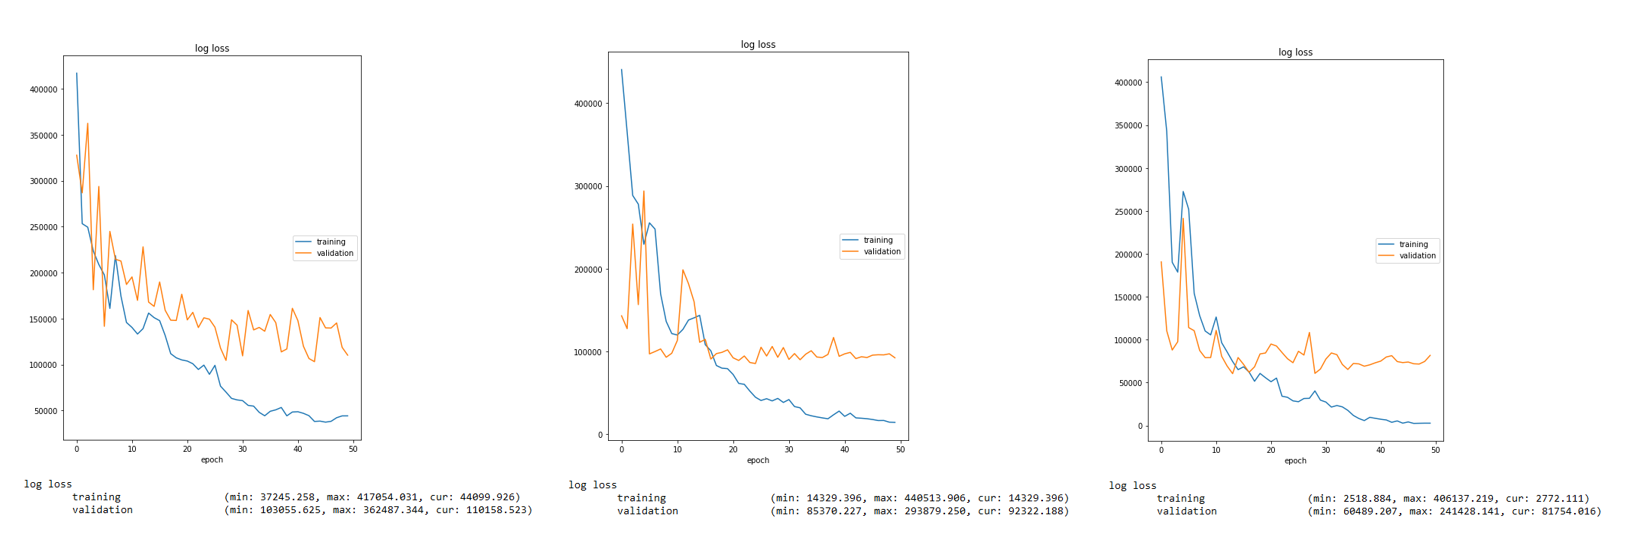

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, size_of_image):
        super(CNNLSTM, self).__init__()
        # self.resnet = resnet101(pretrained=True)
        self.size_of_image = size_of_image
        self.num_layers = 1
        self.hidden_size = 400
        # self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 3000))
        self.lstm_enc = nn.LSTM(input_size=size_of_image*size_of_image, hidden_size=400, num_layers=1, batch_first=True)
        self.fc_enc = nn.Linear(400, 250)
        self.fc_enc2 = nn.Linear(250, 100)
        self.fc_dec1 = nn.Linear(100, 500)
        self.fc_dec2 = nn.Linear(500, 600)
        self.fc_dec3 = nn.Linear(600, size_of_image*size_of_image)
    def init_states_h_c(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=True).to(device),
        torch.zeros(self.num_layers, batch_size, self.hidden_size,  requires_grad=True).to(device))  # initialise the hidden and cell states
    def forward(self, x_3d):
        batch_size = x_3d.size(0)
        hidden_enc = self.init_states_h_c(batch_size)
        out, hidden_enc = self.lstm_enc(x_3d.view(-1, x_3d.size(1), x_3d.size(2)*x_3d.size(3)), hidden_enc)   
        x = self.fc_enc(out[:, -1 ,:])
        # print(x.shape)
        x = torch.tanh(x)
        x = self.fc_enc2(x)
        x = torch.tanh(x)
        x = self.fc_dec1(x)
        x = torch.tanh(x)
        x = self.fc_dec2(x)
        x = torch.tanh(x)
        x = self.fc_dec3(x)

        return x

In [ ]:
def train_rnn_gen(model, optimizer, criterion, dataloader):
    model.train()    # set model to train mode
    train_loss = 0   # initialise the loss
    
    for x, y in dataloader:  # loop over dataset
          print(x.shape)
          x = x.to(device).view(-1, 10, 3, 366, 366)
          y = y.to(device)
          # send data to device
          optimizer.zero_grad()                # reset the gradients
          real_y = y[:,:,1,:,:]
          y_pred = model(x[:, :, 1, :, :])            # get output and hidden state
          loss = criterion(y_pred.view(-1,366*366), real_y.view(-1,366*366))  # compute the loss (change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...)
          train_loss += loss                   

          loss.backward()                      # backpropagate
          optimizer.step()                     # update weights

    return train_loss/len(dataloader)

In [ ]:
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            X = X[:,:,1,:,:]
            a2 = model(X)
            y = y[:,:,1,:,:]
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2.view(-1, 366*366), y.view(-1,366*366))
            validation_loss += loss*X.size(0)
 
            
    return validation_loss/len(data_loader.dataset)

In [ ]:
def go(lr, momentum, n_epochs, model):
    size_of_image = 366
    sequence_length = 4

    #lr = 3e-3
    #momentum = 0.4
    n_epochs = 50
    set_seed(5)
    # test = Sequence().to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)



    # Keep track of losses for plotting
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss = train_rnn_gen(model, optimizer, criterion, dataloader)

        print(epoch, train_loss)

        logs['' + 'log loss'] = train_loss.item()
        logs['val_'+ 'log loss'] = validate(model, criterion, validation_loader).item()
        liveloss.update(logs)
        liveloss.draw()

In [ ]:
class StormTensorDataset(Dataset):
    def __init__(self, train_df, storm_id, transforms=None):
        """
        Args:
            train_df (dataframe): A dataframe containing training set 
            with Image ID, Storm ID, Relative Time, Ocean, and Wind Speed
        """
        self.df = train_df[train_df['Storm ID'] == storm_id]
        self.image_ids = self.df['Image ID'].to_numpy()
        self.relative_times = self.df['Relative Time'].to_numpy(dtype=int)
        self.oceans = self.df['Ocean'].to_numpy(dtype=int)
        self.wind_speeds = self.df['Wind Speed'].to_numpy(dtype=int)
        self.transforms = transforms
        # self.df['Relative Time'] = self.df['Relative Time'].apply(int)
        # self.df['Wind Speed'] = self.df['Wind Speed'].apply(int)
        
        
    def get_image_tensor(self, image_id):
        #img = torchvision.io.read_image('./nasa_tropical_storm_competition/'+train_source+'/'+ train_source+ '_' + image_id + '/image.jpg')
        if colab:
            img = torchvision.io.read_image(str(download_dir)+ '/'+train_source+'/'+train_source+ '_' + image_id + '/image.jpg')
        if windows:
            jpg_path = jpg_path = image_folder + image_id + '/image.jpg'
            img = torchvision.io.read_image(jpg_path)
        return img

        # tensors = []
        # for id in self.df['Image ID']:
        #   img = torchvision.io.read_image('./nasa_tropical_storm_competition/'+train_source+'/'+train_source+ '_' + id + '/image.jpg')
        #   tensors.append(img)
        # tensors = torch.cat(tensors, dim=0)
        # return tensors

    def get_tensor_combination(self, start_pos, number):
        image_id = self.image_ids[0][:4] + str(int(start_pos/100)) + str(int((start_pos/10) % 10)) + str(start_pos % 10)
        if colab:
            img = torchvision.io.read_image(str(download_dir)+ '/'+train_source+'/'+train_source+ '_' + image_id + '/image.jpg')
        if windows:
            jpg_path = jpg_path = image_folder + image_id + '/image.jpg'
            img = torchvision.io.read_image(jpg_path)
        img = img.repeat(3,1,1).type(torch.FloatTensor)
        img = img/255.0
        img = (img -mean)/std
        imgs = [img]
        for i in range(number):
            image_add = int(image_id[4:]) + 1
            image_id = image_id[:4] + str(int(image_add/100)) + str(int((image_add/10) % 10)) + str(image_add % 10)
            
            if colab:
                temp_img = torchvision.io.read_image(str(download_dir)+ '/'+train_source+'/'+train_source+ '_' + image_id + '/image.jpg')
            if windows:
                jpg_path = jpg_path = image_folder + image_id + '/image.jpg'
                temp_img = torchvision.io.read_image(jpg_path)
                temp_img = temp_img.repeat(3,1,1).type(torch.FloatTensor)
                temp_img /= 255.0
                temp_img = (temp_img - mean)/std
                imgs.append(temp_img)
        
        img = torch.stack(imgs, dim=0)
        return img
    

    def tensor_to_image(self, tensor):
        return tensor[0,:,:]
        # images = []
        # for tensor in tensors:
        #   images.append(tensor[0,:,:])
        # return np.array(images)
          

    def __len__(self):
        return len(self.df) // 10 - 1

    def __getitem__(self, idx):
        """
        Args:
          idx: index (int)

        Returns Image ID, Relative Time, Wind Speed, and image tensor
        associated with the index from dataframe
        """
        # get features and image

        image_id = self.image_ids[idx]
        relative_time = self.relative_times[idx]
        wind_speed = self.wind_speeds[idx]
        ocean = self.oceans[idx]

        features = torch.tensor([relative_time, wind_speed, ocean])
        image = self.get_image_tensor(image_id)
        image = image.repeat(3,1,1)
        return self.get_tensor_combination(idx*10 + 1, 9), self.get_tensor_combination(idx*10 + 11, 0)

## Model Performance on Different Storms

Based on the data exploration and classification analysis we have identified different types of storm. Below we evaluate the performance of the model on different storms based on the average wind speed, the number of images available and the number of missing data.
In the analysis below we see the performance over five predicted images deteriorates the further ahead the target. In this model we use all the available information until the first predicted image, but we don’t use new predictions for the next ones.   Since the target in further in the future, we have less reliable information for it and therefore the images are blurrier and details are lost. The improvement to this would be to retrain the model each time we have a new predicted image, so that the information from the new prediction feeds into the consecutive images. Although we would still expect a deterioration, it should not be so high.


### High vs Slow Wind Speed
First let us train the model on the high speed hurricane, as example we chose hurricane ‘gux’ and compare the performance to the low speed hurricate, which we chose ‘scw’ as example.

High Speed Wind:

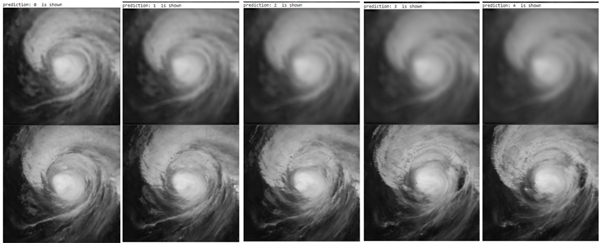

SSIM: [0.97625786 0.97855289 0.97677327 0.97565997 0.97494838]

MSE:  [33.17213115 32.74043716 32.83879781 31.26775956 32.29781421]


Slow Wind Speed:

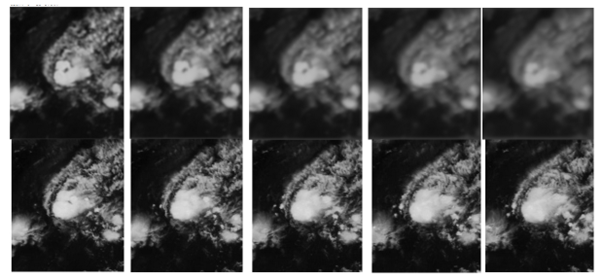

SSIM: [0.94629263 0.94502532 0.94501364 0.94339657 0.94319199]

MSE:  [107.66939891 103.79508197 102.27322404 100.01092896  97.54098361]


The difference in the images for high speed hurricane and low speed hurricane is very noticeable. The high speed hurricane has a more distinct shape and a clear whirlpool. While for low speed hurricane the whirlpool is not as noticeable and it is more like a  mass. This leads to the model performing better on the fast wind hurricane, because there is a clearer pattern in the images which the model is able to pick up and in the predictions we are able to distinguish the same pattern, although some of the details are lost. However in the slow hurricane the denser areas show up in the first prediction but are most in later images and it starts to look less and less like a hurricane. This difference in performance is noticeable in the metrics. For the slow hurricane the MSE is higher than for high speed hurricane, so the average error is higher. However, we can see a downward trend in MSE for each image even though the image itself is less clear. This could be due to how MSE is calculated, it is impacted heavily by the different magnitudes of the pixels, so in the first few images where we have clearer black and white areas, although they look better in an image, the actual errors is impacted more. while for the last few images the image is blurrier so there is smaller difference between the high and low values, meaning that on average the error will be reduced.
In this case the SSIM metric is more reliable for comparison.

We can also see from the validation that the model is overfitting more to the individual batches, because the validation log-loss is very volatile while the training log-loss is smoother.  


Log-loss plot for slow wind model.

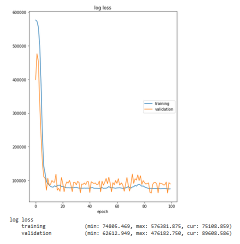

### Number of Images

Next let us compare the impact of number of images has on the performance of the model. Below are two hurricanes with different number of images. The hurricane ‘eoi’ has 488 images, while the hurricane ‘iiz’ has 202 images. In both cases they are fast hurricanes and the whirlpool patterns are clear. 
As expected the hurricane with more images has better performance because it has more information available for training. We have also found that it converges much faster than for hurricane with fewer images. (However we cannot compare the training and validation log-plots because we are using sum MSE for loss which is impacted by the number of images in the dataset, which will be higher for training than for validation.


Using over 400 images.

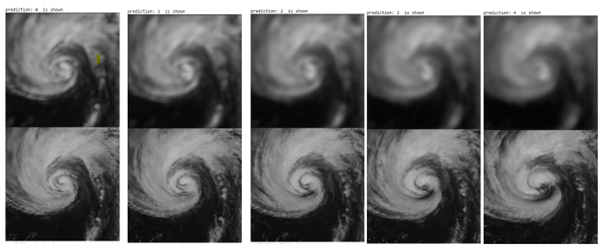



These are the metrics about having lots of images storm 'eoi'

[0.96530899 0.96868977 0.97178325 0.96944426 0.96598805]

[36.04644809 37.5273224  35.48360656 36.32240437 37.06557377]



About 200 images:


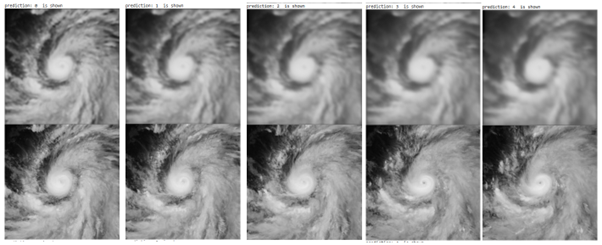

These are the metrics about having less images storm 'iiz'

[0.95586939 0.95417709 0.94922697 0.94706773 0.95206408]

[268.91256831 249.83333333 208.71857923 192.62568306 187.34972678]
